In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter

dataset = pd.read_csv('/Users/eddie/Downloads/Agriculture Data.xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:11].values)
Y = pd.DataFrame(dataset.iloc[:,11:].values)
print(X)
print(Y)
# oversample = SMOTE(sampling_strategy=1)
# X_train, Y_train = oversample.fit_resample(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
counter = Counter(Y)
print(counter)

print(X_train.shape)
print(Y_train.shape)

features = pd.DataFrame(dataset.iloc[:,:16])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10
0      1   1   2  84  27   2   0   1   0   0   0
1      1   1   2  54  25   9   0   0   0   0   0
2      1   1   2  41  41   2   1   0   0   0   0
3      3   3   2  64  34   9   0   0   0   0   0
4      3   1   2  22  13   9   0   0   0   0   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
2482   1   1   1  50  25   9   0   0   0   0   0
2483   1   2   1  58  49   8   0   0   0   0   0
2484   1   2   1   3  36   9   0   0   0   0   0
2485   3   2   2  48  40   9   0   0   0   0   0
2486   1   1   1  81  37   7   0   0   0   0   0

[2487 rows x 11 columns]
      0
0     0
1     0
2     1
3     1
4     1
...  ..
2482  1
2483  0
2484  1
2485  0
2486  1

[2487 rows x 1 columns]
Counter({0: 1})
(1989, 11)
(1989, 1)
Index(['Location of Incident', 'Time', 'Gender', 'Age', 'State',
       'Injury Agent ', 'Confined Space', 'Grain Involved', 'Alcohol/Drugs',
       'Seatbelt', 'Helmet', 'Fatal'],
      dtype='object')


In [2]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU, LayerNormalization, MultiHeadAttention,TimeDistributed, Input, Flatten
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from time import time
import numpy as np
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [3]:

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, Y_train, cv=10, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(init_points=5, n_iter=35)
best_params = optimizer.max['params']

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.6058    | 1.0       | 3.602     | 0.01011   | 5.116     | 232.1     | 1.0       |
| 2         | 0.594     | 1.0       | 1.728     | 0.4028    | 6.772     | 477.3     | 1.0       |
| 3         | 0.6025    | 1.0       | 4.391     | 0.03711   | 7.693     | 475.6     | 1.0       |
| 4         | 0.5715    | 1.0       | 0.9905    | 0.8027    | 9.778     | 382.1     | 1.0       |
| 5         | 0.6002    | 1.0       | 4.473     | 0.09419   | 3.273     | 252.8     | 1.0       |
| 6         | 0.606     | 1.0       | 3.703     | 0.115     | 5.217     | 232.2     | 1.0       |
| 7         | 0.6014    | 1.0       | 5.0       | 0.01      | 10.0      | 464.8     | 1.0       |
| 8         | 0.5541    | 1.0       | 0.0       | 1.0       | 10.0      | 240.9     | 1.0       |
| 9         | 0.5926

In [4]:
model = XGBClassifier(n_estimators=int(best_params['n_estimators']),
                                   gamma=best_params['gamma'],
                                   learning_rate=best_params['learning_rate'],
                                   max_depth=int(best_params['max_depth']),
                                   random_state=42)
model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=984, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
res = model.predict(X_test)
print(Y_test)

from sklearn.metrics import classification_report
print(classification_report(Y_test,res,digits=6))

      0
1696  0
1922  1
792   1
938   0
2072  1
...  ..
1431  0
2108  1
597   0
2399  1
562   1

[498 rows x 1 columns]
              precision    recall  f1-score   support

           0   0.653846  0.106918  0.183784       159
           1   0.699153  0.973451  0.813810       339

    accuracy                       0.696787       498
   macro avg   0.676499  0.540185  0.498797       498
weighted avg   0.684687  0.696787  0.612657       498



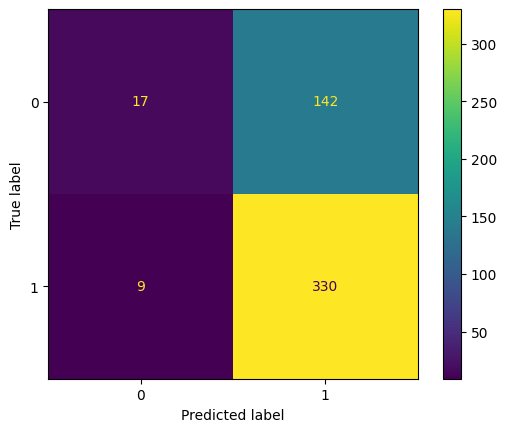

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, res)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()

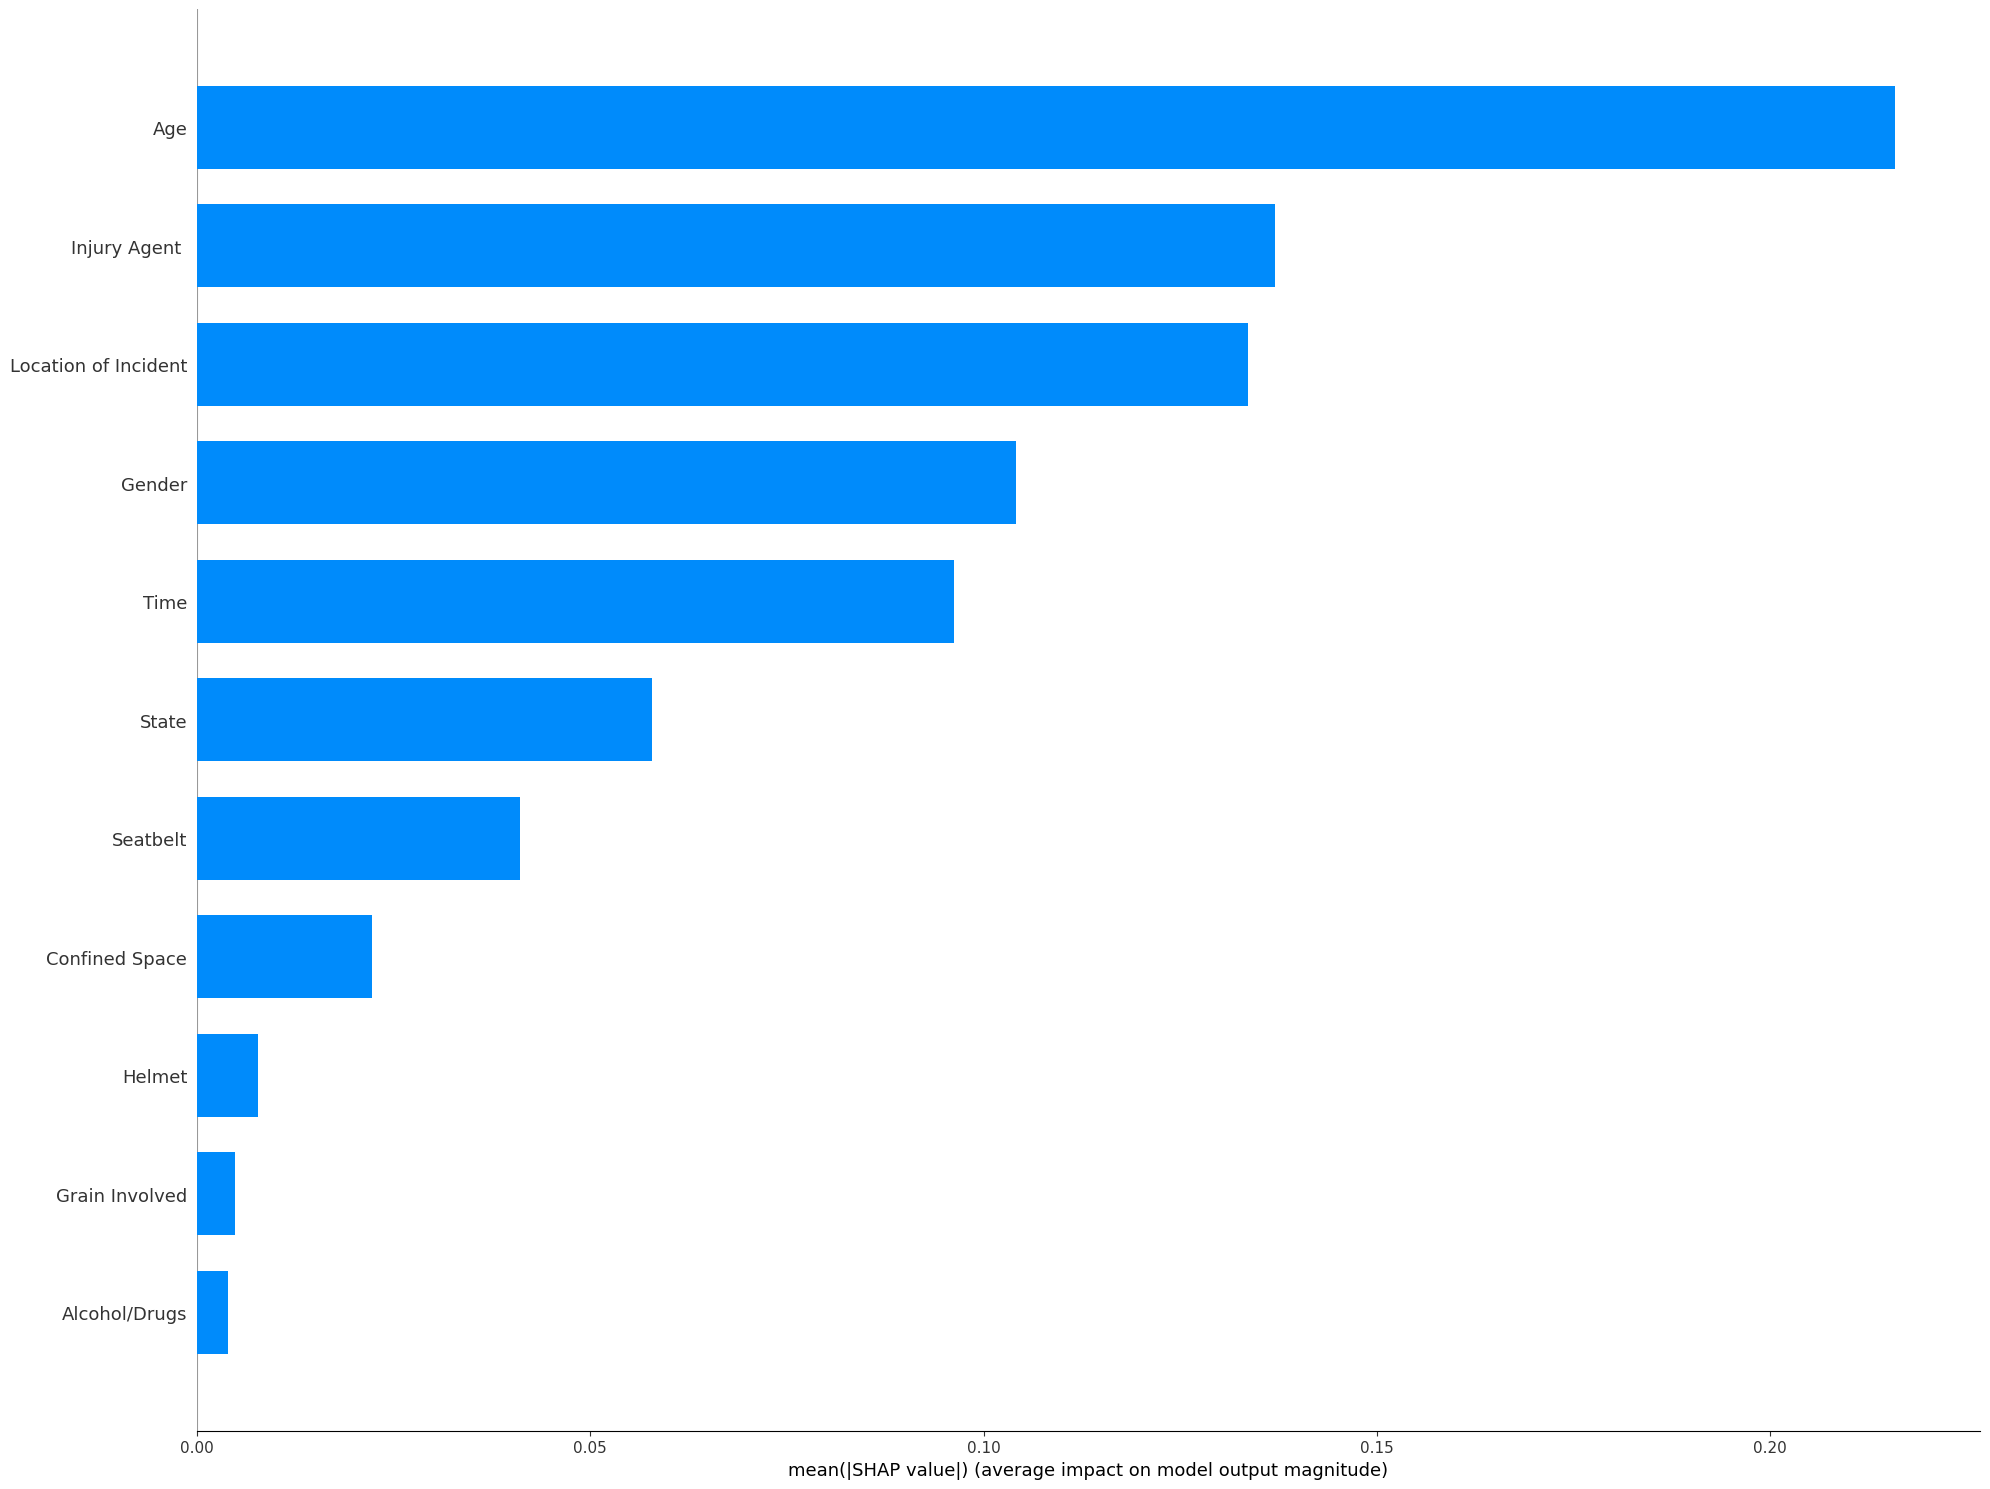

In [20]:
import shap
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features = X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)

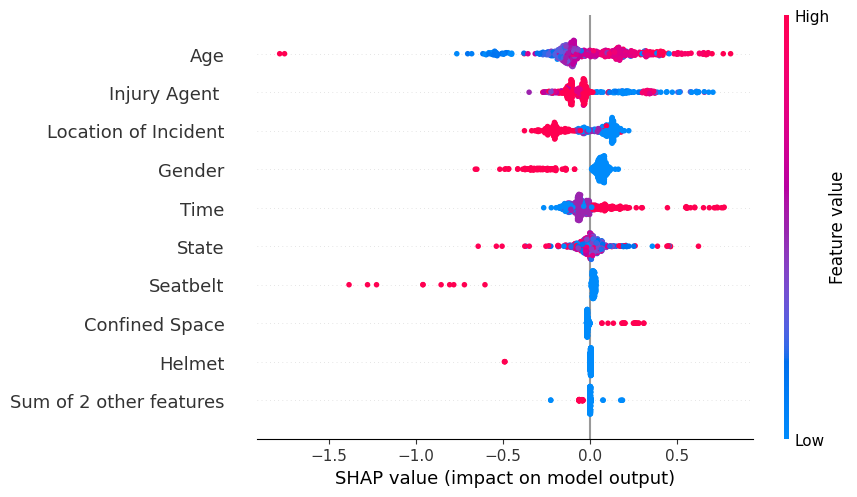

In [22]:
import matplotlib as plt
explanation = shap.Explanation(
    values=shap_values, 
    feature_names=features
)
shap.plots.beeswarm(explanation)

In [17]:
cmap = plt.cm.Blues

# Create the SHAP summary plot with the custom colormap
shap.summary_plot(shap_values, X_test, feature_names=features, plot_color=cmap, plot_size=(10, 6))

TypeError: summary_legacy() got an unexpected keyword argument 'plot_color'